### Tests
Use of the agglomerative clustering with HR diagram.

We test here metrics to detect good solutions for clustering

In [86]:
import sys, os
sys.path.append('../../src')


import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from math import ceil
import math
import gaia_utils as gu
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph
from astroML.correlation import two_point
from astroML.correlation import bootstrap_two_point_angular

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)
rcParams['figure.figsize'] = 9, 6
###################################

clustername = "NGC 1039"
# voname = 'NGC 752-1.0deg.vot'
# voname = 'NGC 2682-3.0deg.vot'
voname = 'NGC 2682-3.0deg.vot'
RADIUS   = 3.0
kCluster = 10
votable_disk = False
distclust = 810.0
WEIGHT = [3.,3.,11.,5.,5., 2., 2., 2.]

## dscan
eps = 0.05
min_samples = 30
## Ward
neighbors = 30

In [87]:
## plot2D and plot3D


def plot2d(df, labels, ilab, cmap = "gist_stern" ,color = False):
    
    rcParams['figure.figsize'] = 14, 14
    f, axarr = plt.subplots(2, 2)
    
    if color:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap )
    else:
        axarr[0,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),1],  s = 0.5, c = "k")
    axarr[0,0].set_xlabel("l")
    axarr[0,0].set_ylabel("b")
    
    axarr[1,0].scatter(df[np.where(labels == ilab),0],df[np.where(labels == ilab),2] , s=0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,0].set_xlabel("l")
    axarr[1,0].set_ylabel("d (pc)")
    
    
    axarr[0,1].scatter(df[np.where(labels == ilab),3],df[np.where(labels == ilab),4] , s= 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[0,1].set_xlabel("Vdra")
    axarr[0,1].set_ylabel("Vdec")
    
    axarr[1,1].scatter(df[np.where(labels == ilab),6],df[np.where(labels == ilab),5] , s = 0.5, c= df[np.where(labels == ilab),2], cmap=cmap)
    axarr[1,1].set_xlabel("G-R")
    axarr[1,1].set_ylabel("G")
    axarr[1,1].set_xlim(-1.,1.5)
    axarr[1,1].set_ylim(27.,10)
    
    plt.show()
    

In [88]:
## astrometric conversion
## 
def convert_to_cartesian(lgal, bga, dist, offCenter = [0., 0.]):
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference. Off is the offset in Lgal,Bgal"
    
    xx = np.zeros(len(lgal))
    yy = np.zeros(len(lgal))
    zz = np.zeros(len(lgal))
    
    lgalOff = lgal - offCenter[0]
    bgalOff = bgal - offCenter[1]
    
    print(offCenter[0])
    print(offCenter[1])
    print(min(lgalOff))
    print(max(lgalOff))
    print(min(bgalOff))
    print(max(bgalOff))
    
    
    for i in range(len(lgal)):
        c = coord.SkyCoord(l=lgalOff[i]*u.degree, b=bgalOff[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    print("## XX")
    print("min, max: %f , %f"%(min(xx),max(xx)))
    print("## YY")
    print("min, max: %f , %f"%(min(yy),max(yy)))
    print("## ZZ")
    print("min, max: %f , %f"%(min(zz),max(zz)))  
        
    return(xx,yy,zz)

In [89]:
## Read the data and do the conversion


source = gu.source(clustername)
source.weight = WEIGHT
source.query(RADIUS, errtol = 0.2, dump = True)
#source.read_votable(voname)
source.convert_filter_data(mag_range = [0., 40])
source.normalization_normal()
#source.normalization_minmax()

SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',40.5208000000,42.7617000000,3.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;
Launched query: 'SELECT * FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),                                      CIRCLE('ICRS',40.5208000000,42.7617000000,3.0000000000)) = 1  AND abs(pmra_error/pmra)<  0.200000  AND abs(pmdec_error/pmdec)< 0.2000000000 AND abs(parallax_error/parallax)< 0.2000000000;'
Retrieving async. results...
## NGC 1039-3.0deg.vot created
## Query for NGC 1039 done
## Total stars: 59908
## Conversion done...
## Stars selected: 52114
## Normalization Normal-Gauss done on filtered data..


()

### Metrics

Metric to quantify goodness-of-solution for the clustering.

In [90]:
def metric1(df, labels, APERTURE = 0.2 , MAXRADIUS = 1. , NBOOTSTRAP =20 ):
    "Using the density contrat assuming the OC is at the center"
    
    xc   = np.mean(df[:,0])
    yc   = np.mean(df[:,1]) 
    
    nlab = max(labels)+1
    aper2 = APERTURE*APERTURE
    metric = {}
    metric['label'] = []
    metric['Q'] = []
    metric['Q_err'] = []
    
    for ilab in range(nlab):
        
        dflab = df[np.where(labels == ilab),:][0]
        radii = (dflab[:,0]- xc)*(dflab[:,0]- xc)+(dflab[:,1]- yc)*(dflab[:,1]- yc)
        nclust = radii[np.where(radii < aper2)]
        dens_clust = len(nclust) / aper2
        
        angle_out = np.random.uniform(0., 2*math.pi, NBOOTSTRAP)
        rad_out   = np.random.uniform(APERTURE,MAXRADIUS-APERTURE, NBOOTSTRAP)
        
        Q_c = np.zeros(NBOOTSTRAP)
        
        for k in range(NBOOTSTRAP): 
            xi = xc + rad_out[k]*math.cos(angle_out[k])
            yi = yc + rad_out[k]*math.sin(angle_out[k])
            radii_out = (dflab[:,0]- xi)*(dflab[:,0]- xi)+(dflab[:,1]- yi)*(dflab[:,1]- yi)
            nout = radii_out[np.where(radii_out < aper2)]
            dens_out_k = max(1,len(nout)) / aper2
            Q_c[k] = dens_clust / dens_out_k
            
        metric['label'].append(ilab)
        metric['Q'].append(np.mean(Q_c))
        metric['Q_err'].append(np.std(Q_c))
        
    return(metric)
                          
        

### Clustering

In [91]:
print("## k-means...")

# KMeans for each normalisation
kmeans = cluster.KMeans(n_clusters= kCluster, max_iter = 2000, n_init = 50)
kmeans.fit(source.dfnorm)
labels_k = kmeans.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_k[np.where(labels_k == i)]), np.median(source.df[np.where(labels_k == i),2]), np.std(source.df[np.where(labels_k == i),2])))
print("##")

###########
print("## Ward... ")
# connectivity matrix for structured Ward

connectivity = kneighbors_graph(source.dfnorm, n_neighbors= neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

ward = cluster.AgglomerativeClustering(n_clusters= kCluster, linkage='ward', connectivity=connectivity)
ward.fit(source.dfnorm)
labels_w = ward.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_w[np.where(labels_w == i)]), np.median(source.df[np.where(labels_w == i),2]),np.std(source.df[np.where(labels_w == i),2])))
print("##")
    
############# 
print("## Spectral...")
spectral = cluster.SpectralClustering(n_clusters = kCluster, eigen_solver='arpack', affinity="nearest_neighbors")
spectral.fit(source.dfnorm)
labels_s = spectral.labels_
for i in range(kCluster):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_s[np.where(labels_s == i)]), np.median(source.df[np.where(labels_s == i),2]),np.std(source.df[np.where(labels_s == i),2])))
print("##")


############# 
print("## DBSCAN...")
dbscan = cluster.DBSCAN(eps, min_samples)
dbscan.fit(source.dfnorm)
labels_d = spectral.labels_
for i in range(max(labels_d)+1):
    print("# Label %5d : %5d  Dist: %6.1f (%5.1f)"%(i,len(labels_d[np.where(labels_d == i)]), np.median(source.df[np.where(labels_d == i),2]), np.std(source.df[np.where(labels_d == i),2]) ))
print("##")


## k-means...
# Label     0 :  4729  Dist: 1696.9 (153.4)
# Label     1 :  7302  Dist:  528.3 (131.6)
# Label     2 :  7627  Dist: 1284.7 (117.0)
# Label     3 :  3567  Dist: 1121.4 (184.5)
# Label     4 :  4824  Dist: 1707.7 (148.1)
# Label     5 :  3128  Dist:  480.6 (163.8)
# Label     6 :  4944  Dist:  850.7 (143.7)
# Label     7 :  2273  Dist: 1202.4 (202.7)
# Label     8 :  6635  Dist:  333.6 (125.5)
# Label     9 :  7085  Dist:  864.9 (125.5)
##
## Ward... 
# Label     0 :  9044  Dist: 1353.2 (161.9)
# Label     1 :  2922  Dist:  938.6 (295.3)
# Label     2 : 11695  Dist:  563.4 (179.1)
# Label     3 :  3857  Dist: 1762.5 (159.7)
# Label     4 :  7019  Dist:  940.9 (177.9)
# Label     5 :  5478  Dist:  340.9 (137.7)
# Label     6 :  2276  Dist:  436.7 (170.6)
# Label     7 :  2315  Dist: 1545.9 (236.5)
# Label     8 :  4796  Dist:  982.2 (137.6)
# Label     9 :  2712  Dist: 1731.9 (164.2)
##
## Spectral...
# Label     0 : 10264  Dist:  796.7 (168.4)
# Label     1 :  3503  Dist: 

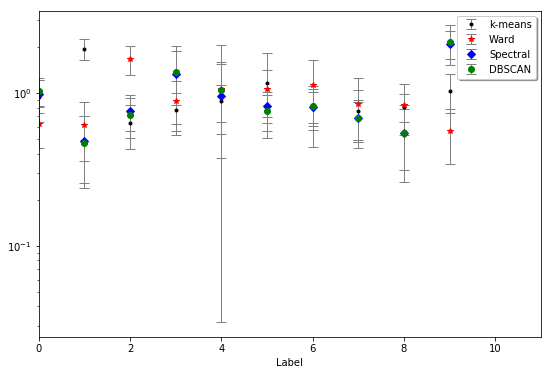

In [92]:
## Metrics of the solutions
np.random.seed(0)
labs = labels_k
qk = metric1(source.df, labs , APERTURE = 0.2 , MAXRADIUS = 0.9 * RADIUS) 
labs = labels_w
qw = metric1(source.df, labs , APERTURE = 0.2 , MAXRADIUS = 0.9 * RADIUS) 
labs = labels_s
qs = metric1(source.df, labs , APERTURE = 0.2 , MAXRADIUS = 0.9 * RADIUS) 
labs = labels_d
qd = metric1(source.df, labs , APERTURE = 0.2 , MAXRADIUS = 0.9 * RADIUS)  

plt.yscale("log", nonposy='clip')
plt.xlim([0,kCluster+1])
plt.errorbar(qk['label'],qk['Q'], qk['Q_err'], label='k-means',fmt='.k', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qw['label'],qw['Q'], qw['Q_err'], label='Ward', fmt='*r', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qs['label'],qs['Q'], qs['Q_err'], label='Spectral', fmt='Db', ecolor='gray', lw=1, capsize=5)
plt.errorbar(qd['label'],qd['Q'], qd['Q_err'], label='DBSCAN', fmt='og', ecolor='gray', lw=1, capsize=5)
plt.legend(loc='upper right', shadow=True)
plt.xlabel("Label")
plt.show()

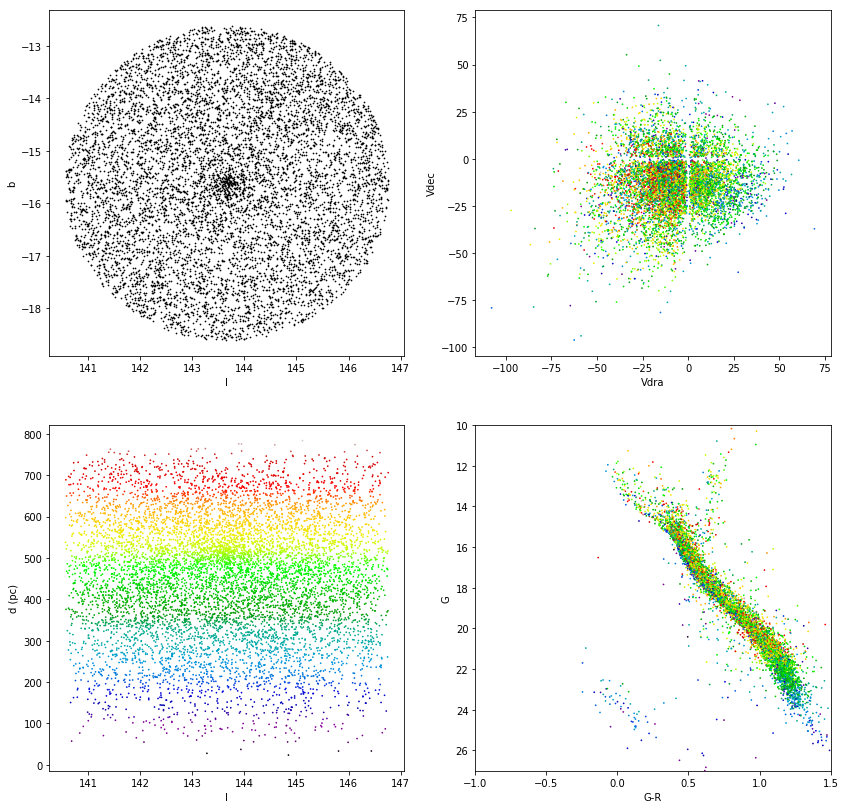

In [94]:
plot2d(source.df, labels_s,9, cmap = "nipy_spectral")